In [295]:
from quantum_electron import FullModel, QuantumAnalysis, PotentialVisualization, package_versions
from quantum_electron.utils import r2xy, crop_potential, find_minimum_location
from quantum_electron.initial_condition import InitialCondition
from scipy.constants import electron_mass as me, elementary_charge as qe
from alive_progress import alive_bar
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

um = 1e-6
GHz = 1e9

package_versions()

quantum_electron 0.2.2
numpy 1.25.2
scipy 1.9.3
matplotlib 3.5.3


This notebook relies on FEM data simulated with `zeroheliumkit`. Please make sure you have it installed to run this notebook.

In [105]:
from zeroheliumkit.fem import FieldAnalyzer

The goal of this notebook is to understand how to use `quantum_electron` with small electron traps. We will look at solving for the electron positions in the dot for various voltages, and in particular, we will see how to deal with additional minima produced by electron reservoirs that connect to the dot. This notebook builds on the knowledge acquired in the previous notebooks, particularly about initial conditions. 

![Package performance](../images/eHe_dot.png)

We will take the electrostatic potential of the device described in [Koolstra, Yang & Schuster, Nature Communications 10 (2019)](https://www.nature.com/articles/s41467-019-13335-7), which can be found in the `fem_data` folder. 

# Zoomed-out potential overview

Let's load the data

In [313]:
phi = FieldAnalyzer(("fem_data/nat_comm_dot_zoomed_out.txt", 'phi', '2Dmap'))

The electrodes in the picture above correspond to the following labels:
- Trap - `trap`
- Resonator - `resonator_1` and `resonator_2`
- Trap guard - `trapgu`
- Res guard - `resgu`

In [314]:
phi.phi.keys()

dict_keys(['gnd', 'resgu', 'resonator_1', 'resonator_2', 'trap', 'trapgu', 'xlist', 'ylist'])

In [315]:
voltages = {'resgu' : -0.43, 
            'resonator_1' : 0.6,
            'resonator_2' : 0.6,
            'trap' : 0.25,
            'trapgu' : -0.2,
            'gnd' : 0.0}

p = PotentialVisualization(phi.phi, voltages.copy())

Let's first take a bird's eye view at the dot area

{'resgu': 0.07677094025,
 'resonator_1': 0.1674716714,
 'resonator_2': 0.1708451432,
 'trap': 0.2339110633,
 'trapgu': 0.07345500379,
 'gnd': 0.2775942661}

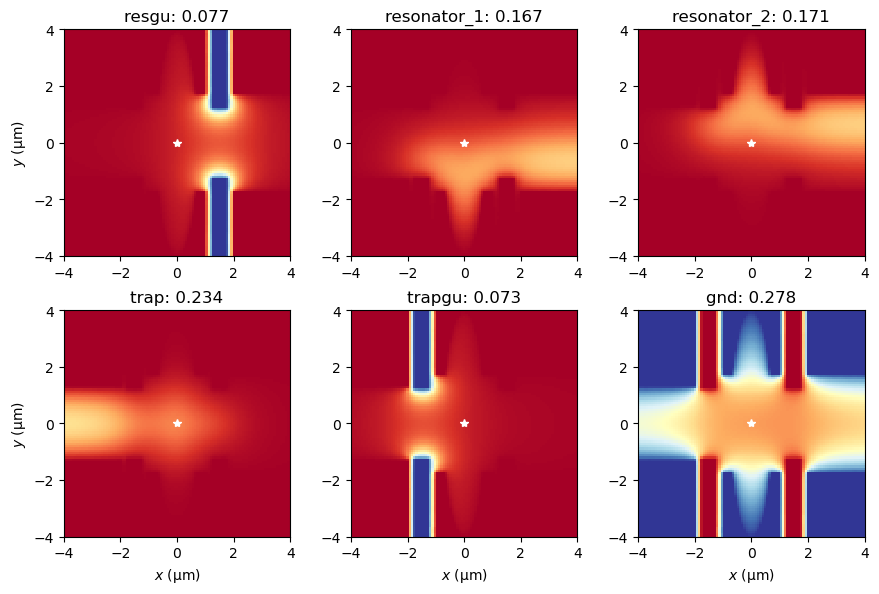

In [316]:
p.plot_coupling_constants(loc=(0, 0), plot_coor=(0, 0), plot_dxdy=(8, 8))

## Suitable trapping potential 

From [Koolstra, Yang & Schuster, Nature Communications 10 (2019)](https://www.nature.com/articles/s41467-019-13335-7) we can find suitable voltages that result in a small dot near the tip of the resonator. Throughout this notebook, we'll fix the resonator voltage at 0.6V, as was done in the experiment in the paper.

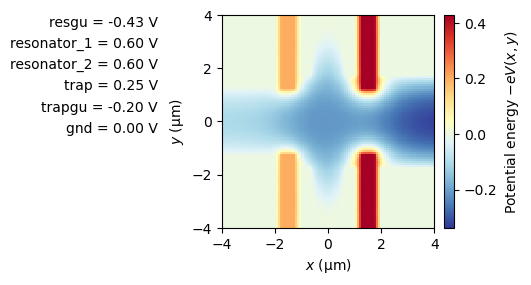

In [148]:
voltages = {'resgu' : -0.15, 
            'resonator_1' : 0.6,
            'resonator_2' : 0.6,
            'trap' : 0.25,
            'trapgu' : -0.1,
            'gnd' : 0.0}

p.plot_potential_energy(dxdy=(8,8), figsize=(3, 3))

A slice along the channel indeed shows there is a dot near $x\approx 0$

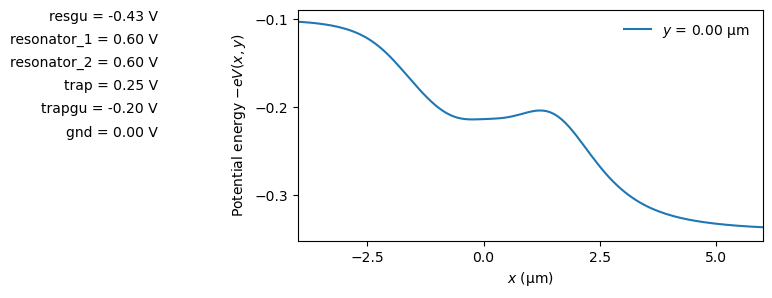

In [149]:
p.plot_potential_slice(y=[0], x=[-4, 6])

If we want to put electrons in the dot, we observe a problem: they can't be contained because the minimum of the potential is always at the resonator. To try this, run the code below. Note that there are no more electrons in the dot after minimizing the energy.

In [323]:
voltages = {'resgu' : -0.35, 
            'resonator_1' : 0.6,
            'resonator_2' : 0.6,
            'trap' : 0.25,
            'trapgu' : -0.1,
            'gnd' : 0.0}

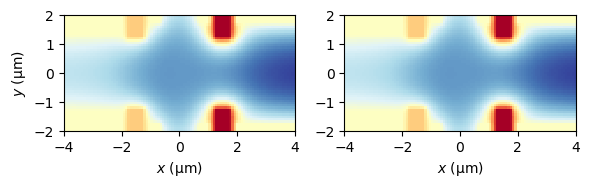

In [324]:
n_electrons = 2
fig, ax = plt.subplots(1, n_electrons, figsize=(6, 4))

for k in range(n_electrons):
    fm = FullModel(potential_dict=phi.phi, voltage_dict=voltages)
    res = fm.get_electron_positions(n_electrons=k+1, electron_initial_positions=None)

    fm.plot_potential_energy(ax=ax[k], dxdy=(8, 4), print_voltages=False, plot_contours=False)
    fm.plot_electron_positions(res, ax=ax[k])

    if k > 0:
        ax[k].set_ylabel("")

fig.tight_layout()

## Cropping the potential to keep electrons trapped

There are two ways to deal with the escaping electrons. The first way is to crop the zoomed-out FEM data:

In [177]:
# Crop potentials
potential_dict = {}

extent = 1.4
new_xrange = (-extent, extent)
new_yrange = (-extent, extent)

for electrode_name in phi.phi.keys():
    if electrode_name not in ['xlist', 'ylist']:
        potential_dict['xlist'], potential_dict['ylist'], potential_dict[electrode_name] = crop_potential(phi.phi['xlist'], phi.phi['ylist'], phi.phi[electrode_name], xrange=new_xrange, yrange=new_yrange)    

Now, indeed it is possible to keep electrons contained inside the dot

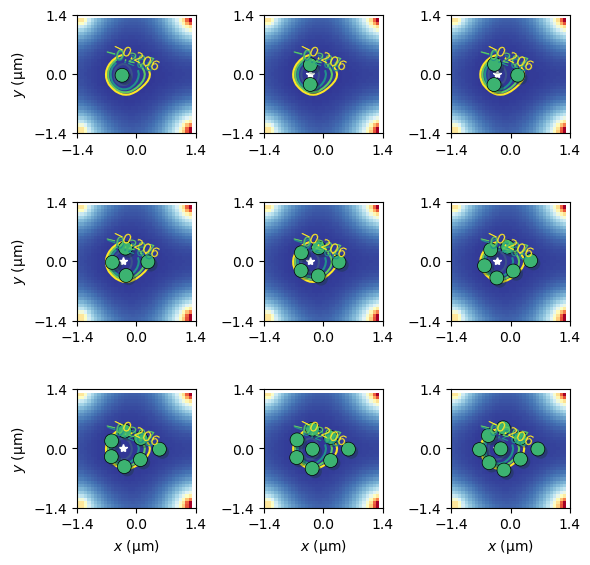

In [183]:
n_electrons = 9
fig, ax = plt.subplots(3, 3, figsize=(6, 6))

for k in range(n_electrons):
    axis = ax.flatten()[k]
    
    fm = FullModel(potential_dict=potential_dict, voltage_dict=voltages, trap_annealing_steps=[1.0]*10, remove_bounds=[-extent * um, extent * um])
    res = fm.get_electron_positions(n_electrons=k+1, electron_initial_positions=None)

    fm.plot_potential_energy(ax=axis, dxdy=(extent, extent), print_voltages=False, plot_contours=True)
    fm.plot_electron_positions(res, ax=axis)

    # Configure the axis and ticklabels for a clean look
    if k not in [0, 3, 6]:
        axis.set_ylabel("")
        
    if k not in [6, 7, 8]:
        axis.set_xlabel("")
        
    axis.set_xticks([-extent, 0, extent])
    axis.set_yticks([-extent, 0, extent])

fig.tight_layout()

This method works, but as can be seen above, the finite resolution of the data set starts to show.

# Using the zoomed-in potential

A second way to avoid electrons escaping and convergence issues is to use a re-exported version of the FEM data on a very fine grid. Such a fine grid will avoid discrete steps in the minimized electron positions. Let's load this new data set:

In [333]:
phi = FieldAnalyzer(("fem_data/nat_comm_dot_zoomed_in.txt", 'phi', '2Dmap'))

In [328]:
voltages = {'resgu' : -0.35, 
            'resonator_1' : 0.6,
            'resonator_2' : 0.6,
            'trap' : 0.25,
            'trapgu' : -0.1,
            'gnd' : 0.0}

Solve for the equilibrium positions of the first 9 electron clusters.

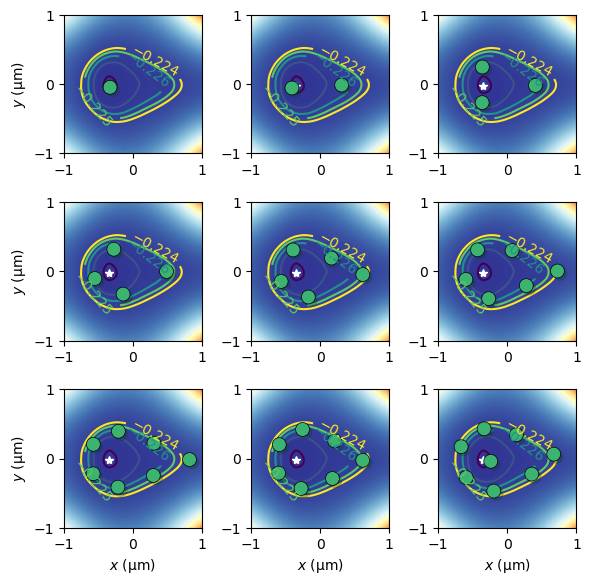

In [329]:
n_electrons = 9
fig, ax = plt.subplots(3, 3, figsize=(6, 6))

for k in range(n_electrons):
    axis = ax.flatten()[k]
    
    fm = FullModel(potential_dict=phi.phi, voltage_dict=voltages, trap_annealing_steps=[1.0]*10)
    res = fm.get_electron_positions(n_electrons=k+1, electron_initial_positions=None)

    fm.plot_potential_energy(ax=axis, dxdy=(2, 2), print_voltages=False, plot_contours=True)
    fm.plot_electron_positions(res, ax=axis)

    # Configure the axis and ticklabels for a clean look
    if k not in [0, 3, 6]:
        axis.set_ylabel("")
        
    if k not in [6, 7, 8]:
        axis.set_xlabel("")
        
    axis.set_xticks([-1, 0, 1])
    axis.set_yticks([-1, 0, 1])

fig.tight_layout()

If we want to study larger electron clusters, it is useful to revisit the `InitialCondition` helper class, which gives us finer control of the initial placement of electrons. From here, the equilbrium positions are found with more success.

We will use a initial condition based on the chemical potential: the code will detect the dot area, fill the dot with `n_electrons` electrons and place them randomly with a minimum distance of `min_spacing` (if it is able to).

Text(0.5, 1.0, '19/30 electrons left in the dot')

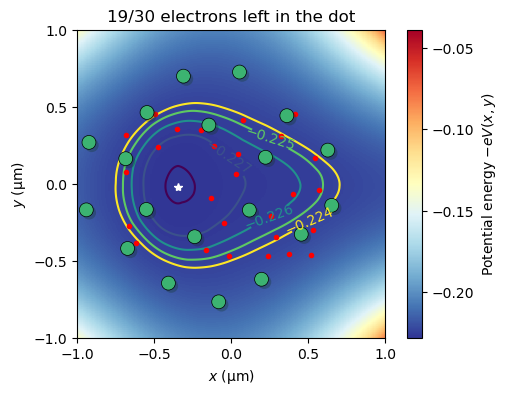

In [330]:
n_electrons = 30

# dU controls the filling level for the initial condition. A lower number will place electrons near the potential minimum. 
# If this number is too small and n_electrons too large, there may not be enough room to fill the potential with electrons.
dU = 3e-3
min_spacing = 0.12 # micron

fm = FullModel(potential_dict=phi.phi, voltage_dict=voltages, trap_annealing_steps=[1.0]*10, 
               remove_bounds=(-1e-6, 1e-6), remove_unbound_electrons=True)
fm.plot_potential_energy(ax=None, dxdy=(2, 2), print_voltages=False, plot_contours=True)

ic = InitialCondition(phi.phi, voltages)
# Find the minimum value of the potential
_, _, U_min = find_minimum_location(phi.phi, voltages, return_potential_value=True)
chem_potential = ic.make_by_chemical_potential(max_electrons=n_electrons, chemical_potential=U_min + dU, min_spacing=min_spacing)

plt.plot(chem_potential[::2] * 1e6, chem_potential[1::2] * 1e6, '.r')

res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=chem_potential, verbose=False)
fm.plot_electron_positions(res, ax=None)

plt.title(f"{fm.count_electrons_in_dot(res['x'])}/{n_electrons} electrons left in the dot")

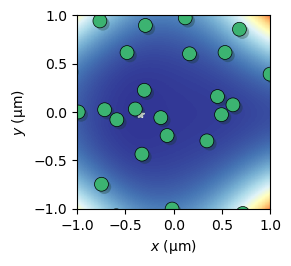

In [331]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
anim = fm.animate_convergence(fig=fig, ax=ax, frame_interval_ms=50)

In [332]:
fm.show_animation(anim)

We're going to stick with the zoomed-in potential and try to make sense of some results in the paper. 

## Demonstrate unloading with the Trapguard electrode

Figure 3 in [Koolstra, Yang & Schuster, Nature Communications 10 (2019)](https://www.nature.com/articles/s41467-019-13335-7) shows that the dot can be unloaded using the Trapguard electrode. We will show similar behavior in this section. First, pick voltages for the other electrodes. Note that the value of `trapgu` will be swept, so the value chosen here won't have any effect.

Here, we'll also set the options for the solver. Important note: the `trap_annealing_steps` is an important parameter. For the last few electrons the barrier to the reservoir can become small, and therefore, the stronger kicks for annealing steps at higher temperatures can cause electrons to escape prematurely! Try playing with this parameter, e.g. compare `"trap_annealing_steps" : [0.1] * 10` with `"trap_annealing_steps" : [1.0] * 10`

In [227]:
voltages = {'resgu' : -0.5, 
            'resonator_1' : 0.6,
            'resonator_2' : 0.6,
            'trap' : 0.22,
            'trapgu' : 0.0,
            'gnd' : 0.0}

options = {"include_screening" : False, # Include screening of electron-electron interactions due to thin film.
           "screening_length" : 2e-6, # Typically helium thickness.
           "potential_smoothing" : 1e-4, # Numerical smoothing of the splines (gets rid of some noise, can introduce artifacts)
           "remove_unbound_electrons" : True, # Removes electrons if they shot outside the solution box.
           "remove_bounds" : (-1.0 * um, 1.0 * um), # Sets which electrons should be removed if above is True.
           "trap_annealing_steps" : [0.2] * 10, # List of annealing temperatures, length determines the number of steps
           "max_x_displacement" : 0.1e-6, # Maximum x-displacement of solved electron positions during annealing.
           "max_y_displacement" : 0.1e-6} # Maximum y-displacement of solved electron positions during annealing.

We will now loop over the different trapguard voltages. For the first iteration, we use the `make_by_chemical_potential` initial condition as a starting point. We will then solve for the minimum energy configuration. For each subsequent iteration in the for-loop, we can use the previously found positions. If you like to start with a fresh initial guess for the minimizer, set `use_previous_initial_state=False`. 

In [228]:
use_previous_initial_state = True

# Initial number of electrons, not guaranteed to fit in the dot!
N_init = 15

# Sweep the trapguard more negative to unload the dot
sweep_electrodes = ['trapgu']
sweep = np.linspace(-0.00, -0.70, 71)

num_electrons = np.zeros((len(sweep)))
electron_configurations = []
voltage_configurations = []

with alive_bar(len(sweep), force_tty=True) as bar:
    for n, sw in enumerate(sweep):
        for sweep_electrode in sweep_electrodes:
            voltages[sweep_electrode] = sw

        f = FullModel(phi.phi, voltages, **options)

        # Start with the same initial condition
        if n == 0: 
            ic = InitialCondition(phi.phi, voltages)
            # Find the minimum value of the potential
            _, _, U_min = find_minimum_location(phi.phi, voltages, return_potential_value=True)
            dU = 3e-3
            min_spacing = 0.12
            
            electron_initial_positions = ic.make_by_chemical_potential(max_electrons=N_init, 
                                                                       chemical_potential=U_min + dU, 
                                                                       min_spacing=min_spacing)
            
            N = len(electron_initial_positions) // 2
        elif use_previous_initial_state: 
            electron_initial_positions = res['x']
            N = len(electron_initial_positions) // 2
        else:
            electron_initial_positions = None
            N = N_init

        # Minimize the electron energy if there's any electrons left in the dot
        if N > 0:
            res = f.get_electron_positions(n_electrons=N, 
                                           electron_initial_positions=electron_initial_positions, 
                                           verbose=False, 
                                           suppress_warnings=True)

            num_electrons[n] = f.count_electrons_in_dot(res['x'])
            electron_configurations.append(res['x'])
        else:
            electron_configurations.append(np.array([]))
            
        voltage_configurations.append(voltages)

        bar()

|████████████████████████████████████████| 71/71 [100%] in 8.7s (7.85/s)                                                


The number of electrons indeed decreases as the trapguard is swept more negative. The numbers differ slightly from the paper, because the voltages and simulated channel depth are slightly different. 

(-0.7, -0.0)

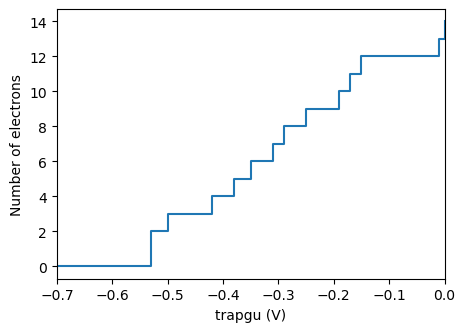

In [229]:
fig = plt.figure(figsize=(5.,3.5))
plt.step(sweep, num_electrons)
plt.xlabel(f"{''.join(sweep_electrodes)} (V)")
plt.ylabel("Number of electrons")
plt.xlim(np.min(sweep), np.max(sweep))

We will now visualize how electrons leave the dot, by using `animate_voltage_sweep`. 

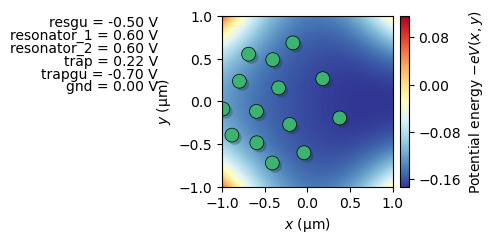

In [230]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
anim = f.animate_voltage_sweep(fig, ax, voltage_configurations, 
                               electron_configurations, 
                               coor=(0, 0), 
                               dxdy=(2, 2), 
                               frame_interval_ms=100)

In [231]:
f.show_animation(anim)

## Controlling the number of electrons

Now that we have a feel of how to sweep voltages, we can see the interplay of the unloading and potential barrier. 

In [294]:
use_previous_initial_state = True

# Initial number of electrons
N_init = 10

# Sweep the trapguard more negative to unload the dot
sweep_electrodes = ['trapgu']
sweep = np.linspace(-0.00, -0.60, 41)

# Repeat the unload sweep for various resguards
step_electrodes = ['resgu']
step = np.linspace(-0.7, -0.4, 31)

num_electrons = np.zeros((len(step), len(sweep)))

with alive_bar(len(step)*len(sweep), force_tty=True) as bar:
    for n, st in enumerate(step):
        for step_electrode in step_electrodes:
            voltages[step_electrode] = st
            
        for k, sw in enumerate(sweep):
            for sweep_electrode in sweep_electrodes:
                voltages[sweep_electrode] = sw

            f = FullModel(phi.phi, voltages, **options)

            # Every new step (when k == 0) start with the same initial condition
            if k == 0: 
                ic = InitialCondition(phi.phi, voltages)
                # Find the minimum value of the potential
                _, _, U_min = find_minimum_location(phi.phi, voltages, return_potential_value=True)
                dU = 3e-3
                min_spacing = 0.12
                
                electron_initial_positions = ic.make_by_chemical_potential(max_electrons=N_init, 
                                                                           chemical_potential=U_min + dU, 
                                                                           min_spacing=min_spacing)
                
                N = len(electron_initial_positions) // 2
            elif use_previous_initial_state: 
                electron_initial_positions = res['x']
                N = len(electron_initial_positions) // 2
            else:
                electron_initial_positions = None
                N = N_init

            if N > 0:
                res = f.get_electron_positions(n_electrons=N, 
                                               electron_initial_positions=electron_initial_positions, 
                                               verbose=False, 
                                               suppress_warnings=True)

                num_electrons[n, k] = f.count_electrons_in_dot(res['x'])

            bar()

|████████████████████████████████████████| 1271/1271 [100%] in 2:44.8 (7.70/s)                                          ~2:40, 6.7/s) ▆█▆ 194/1271 [15%] in 29s (~2:40, 6.7/s)  199/1271 [16%] in 30s (~2:39, 6.7/s) █▆▄ 244/1271 [19%] in 36s (~2:33, 6.7/s) ▄▆█ 423/1271 [33%] in 1:02 (~2:05, 6.8/s) (~1:58, 6.8/s) ▅▇▇ 483/1271 [38%] in 1:11 (~1:56, 6.8/s) ▇▅▃ 525/1271 [41%] in 1:17 (~1:49, 6.8/s)  539/1271 [42%] in 1:19 (~1:47, 6.8/s) ▇▅▃ 564/1271 [44%] in 1:23 (~1:44, 6.8/s) (~1:33, 6.9/s) ▆█▆ 634/1271 [50%] in 1:32 (~1:33, 6.9/s) (~1:09, 7.0/s)  877/1271 [69%] in 2:03 (~56s, 7.1/s)  ▁▃▅ 994/1271 [78%] in 2:18 (~38s, 7.2/s) 


The figure below shows the number of trapped electrons for various Resonator guard and Trapguard voltages. The plateaus show that a larger potential barrier (more negative `resgu` value) requires a more negative unload value to empty the dot into the resonator reservoir.

(-0.7, -0.4)

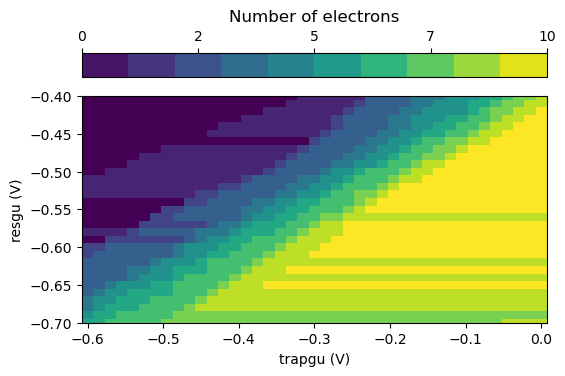

In [296]:
# extract all colors from the cmap
cmap = plt.cm.RdYlBu_r
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(0, N_init+0.1, 1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(6, 5))
pcm = plt.pcolormesh(sweep, step, num_electrons)
plt.xlabel(f"{''.join(sweep_electrodes)} (V)")
plt.ylabel(f"{''.join(step_electrodes)} (V)")
plt.gca().set_aspect('equal')

cbar = plt.colorbar(pcm, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal',
                    location='top', ticks=np.linspace(0, N_init, 5), boundaries=bounds, format='%1i')
cbar.ax.set_title("Number of electrons")
plt.clim(0, N_init)

plt.ylim(np.min(step), np.max(step))

This means the resonator guard and trapguard work against each other. This can also be seen from the potential maps in each of the four corners of this map above. Below we'll show these plots. Note how the top right and bottom left potentials are similar: a more negative resonator guard can cover for a more negative trapguard and vice versa.

WARNING in creating initial condition: could not fit more than 7 electrons.


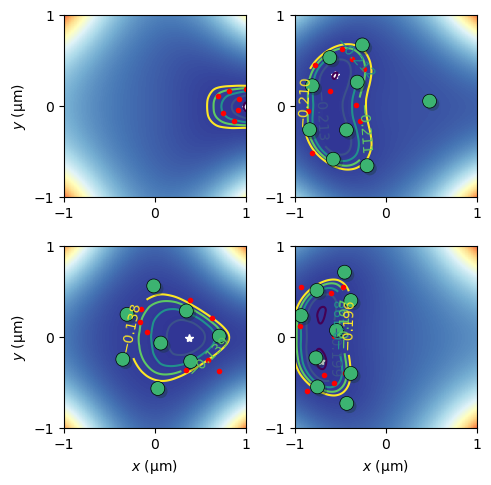

In [298]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))

plot_vs = [(np.max(step), np.min(sweep)), 
           (np.max(step), np.max(sweep)), 
           (np.min(step), np.min(sweep)), 
           (np.min(step), np.max(sweep))]

for k in range(4):
    axis = ax.flatten()[k]
    
    for step_electrode in step_electrodes:
        voltages[step_electrode] = plot_vs[k][0]
        
    for sweep_electrode in sweep_electrodes:
        voltages[sweep_electrode] = plot_vs[k][1]            
    
    fm = FullModel(potential_dict=phi.phi, voltage_dict=voltages, trap_annealing_steps=[1.0]*10)
    fm.plot_potential_energy(ax=axis, dxdy=(2, 2), print_voltages=False, plot_contours=True)
    
    # Make the initial condition
    ic = InitialCondition(phi.phi, voltages)
    _, _, U_min = find_minimum_location(phi.phi, voltages, return_potential_value=True)
    chem_potential = ic.make_by_chemical_potential(max_electrons=N_init, chemical_potential=U_min + dU, min_spacing=min_spacing)
    
    axis.plot(chem_potential[::2] * 1e6, chem_potential[1::2] * 1e6, '.r')

    res = fm.get_electron_positions(n_electrons=n_electrons, electron_initial_positions=chem_potential, verbose=False)
    fm.plot_electron_positions(res, ax=axis)

    # Configure the axis and ticklabels for a clean look
    if k not in [0, 2]:
        axis.set_ylabel("")
        
    if k not in [2, 3]:
        axis.set_xlabel("")
        
    axis.set_xticks([-1, 0, 1])
    axis.set_yticks([-1, 0, 1])

fig.tight_layout()

# Single Electron Microwave Properties

The last figure in [Koolstra, Yang & Schuster, Nature Communications 10 (2019)](https://www.nature.com/articles/s41467-019-13335-7) shows that a single electron frequency can be made to cross with the superconducting resonator. In this section we confirm this behavior!

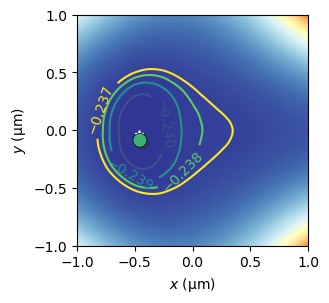

In [302]:
voltages = {'resgu' : -0.3, 
            'resonator_1' : 0.6,
            'resonator_2' : 0.6,
            'trap' : 0.25,
            'trapgu' : 0.0,
            'gnd' : 0.0}

use_previous_initial_state = True

fm = FullModel(potential_dict=phi.phi, voltage_dict=voltages, trap_annealing_steps=[1.0]*10, 
               remove_unbound_electrons=True, remove_bounds=[-1e-6, 1e-6])

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

res = fm.get_electron_positions(n_electrons=1, electron_initial_positions=None, verbose=False)

fm.plot_potential_energy(ax=ax, dxdy=(2, 2), print_voltages=False, plot_contours=True)
fm.plot_electron_positions(res, ax=ax)

Up to now we haven't added any knowledge about the resonator. We're fixing that here by specifying the resonance frequency and characteristic impedance of the resonator. From there we calculate the effective inductance and capacitance of the circuit from https://arxiv.org/pdf/2410.19592. Such parameters are fed into `setup_eom` through `resonator_dict`

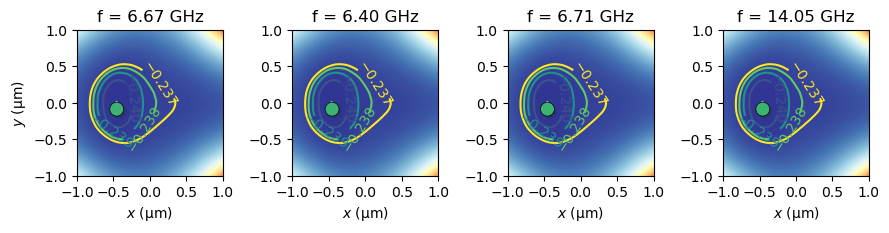

In [303]:
f0 = 6.40e9
Z0 = 100

omega0 = 2 * np.pi * f0
L = Z0 / omega0
Cdot = 0.1e-13
C = 1 / (omega0**2 * L) - 2*Cdot

resonator_dict = {"L1" : L, "C1" : C, 
                  "L2" : L, "C2" : C, "Cdot" : Cdot, "mode" : "diff"}

fm.set_rf_interpolator(rf_electrode_labels=['resonator_1', 'resonator_2'])
K, M = fm.setup_eom_coupled_lc(res['x'], resonator_dict)
eigenfrequencies, evecs = fm.solve_eom(K, M)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(9, 3.5))

# qa = QuantumAnalysis(phi.phi, voltages)
for k, ax in enumerate(axs):
    fm.plot_potential_energy(ax=ax, coor=[0, 0], dxdy=(2, 2), print_voltages=False, plot_contours=True)
    
    if k >= 1: 
        ax.set_ylabel("")
    
    ax.set_title(f"f = {eigenfrequencies[k]/1e9:.2f} GHz")

fig.tight_layout()
    
ani = fm.animate_eigenvectors(fig, axs, evecs.T, res['x'], amplitude=0.10e-6, time_points=21, frame_interval_ms=25)

In [284]:
f.show_animation(ani)

For the voltages chosen above, there are two closely spaced resonator frequencies. In addition, the higher frequency modes are the electron modes.

Here we show that we can sweep the trap voltage to cross the microwave resonance modes:

In [304]:
trap_voltages = np.linspace(0.18, 0.30, 31)
mode_frequencies = np.zeros((len(trap_voltages), 4))

for k, trap in enumerate(trap_voltages):
    voltages['trap'] = trap    

    fm = FullModel(potential_dict=phi.phi, voltage_dict=voltages, trap_annealing_steps=[1.0]*10, 
                   remove_unbound_electrons=True, remove_bounds=[-1e-6, 1e-6])

    res = fm.get_electron_positions(n_electrons=1, electron_initial_positions=None, verbose=False)

    fm.set_rf_interpolator(rf_electrode_labels=['resonator_1', 'resonator_2'])
    K, M = fm.setup_eom_coupled_lc(res['x'], resonator_dict)
    eigenfrequencies, evecs = fm.solve_eom(K, M, sort_by_cavity_participation=True)
    
    mode_frequencies[k, :] = eigenfrequencies

Text(0, 0.5, 'Mode frequencies (GHz)')

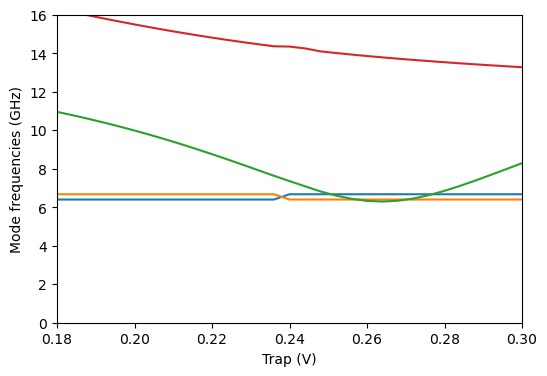

In [312]:
fig = plt.figure(figsize=(6., 4.))
plt.plot(trap_voltages, mode_frequencies / GHz)
plt.xlim(trap_voltages.min(), trap_voltages.max())
plt.ylim(0, 16)
plt.xlabel("Trap (V)")
plt.ylabel("Mode frequencies (GHz)")